# Introdução

**Análise dos Sinais de Posição do Acelerômetro MPU6050**

Foi realizado a análise dos sinais de posição captados pelo acelerômetro do sensor MPU6050 nas direções X, Y e Z.

Código em arduino utilizado para a captura dos dados:

In [ ]:
"""

#include <Wire.h>
#include <MPU6050.h>

#define MPU6050_SAMPLERATE_DELAY_MS (100) // Taxa de amostragem
MPU6050 mpu;

void setup() {
  Serial.begin(115200);
  Wire.begin();
  mpu.initialize();
  delay(1000);
}

void loop() {
  int16_t ax, ay, az;

  for (int i = 0; i < 1000; i++) {
    mpu.getAcceleration(&ax, &ay, &az);
    Serial.print((float)ax / 16384.0); // divide pelo valor de escala do acelerômetro
    Serial.print(",");
    Serial.print((float)ay / 16384.0);
    Serial.print(",");
    Serial.println((float)az / 16384.0);
    delay(MPU6050_SAMPLERATE_DELAY_MS);
  }

  // encerre o loop após coletar os mil dados
  while (true) {
  }
}

"""

In [ ]:
import pandas as pd
from google.colab import drive

In [ ]:
# def um limite: mil linhas e 3 colunas (x, y e z)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 3)

In [ ]:
drive.mount('/content/drive')
data = pd.read_csv('/content/drive/MyDrive/mildadosMPU6050.csv')
print(data.head()) # mostrar as primeiras linhas do dataframe

Mounted at /content/drive
      x     y     z
0 -0.20 -0.04  0.92
1 -0.21 -0.03  0.92
2 -0.21 -0.04  0.91
3 -0.21 -0.04  0.91
4 -0.21 -0.04  0.91


In [ ]:
# verifica o número de linhas:
print(len(data))

1000


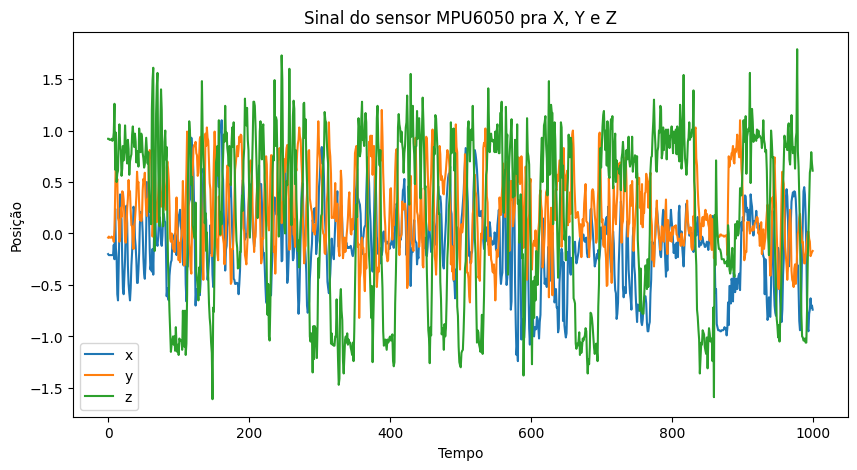

In [ ]:
import matplotlib.pyplot as plt

signal = data[['x', 'y', 'z']] # as 3 colunas

plt.figure(figsize=(10, 5))
plt.plot(signal)
plt.title('Sinal do sensor MPU6050 pra X, Y e Z')
plt.xlabel('Tempo')
plt.ylabel('Posição')
plt.legend(['x', 'y', 'z'])
plt.show()

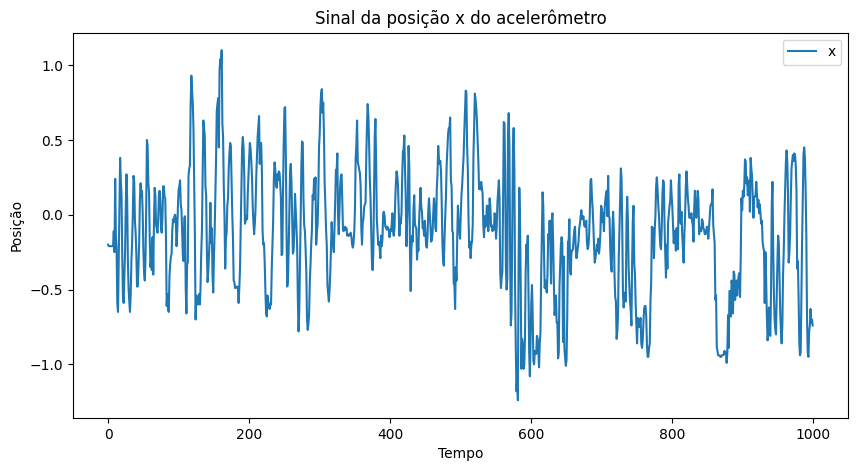

In [ ]:
import matplotlib.pyplot as plt

signal = data[['x']] # só para x

plt.figure(figsize=(10, 5))
plt.plot(signal)
plt.title('Sinal da posição x do acelerômetro')
plt.xlabel('Tempo')
plt.ylabel('Posição')
plt.legend(['x'])
plt.show()

A melhor classificação, dado o seu comportamento, é a randômica.

Agora, convertendo o sinal coletado para o domínio da frequência usando a função fft(x):

# Transformada Rápida de Fourier (FFT):

$ X(k) = \sum_{n=0}^{N-1} x(n) \cdot e^{-i2\pi kn/N} $


- \( X(k) \) representa o \( k \)-ésimo coeficiente na transformada de Fourier.
- \( x(n) \) é a amostra do sinal no tempo \( n \).
- \( N \) é o número total de amostras no sinal.

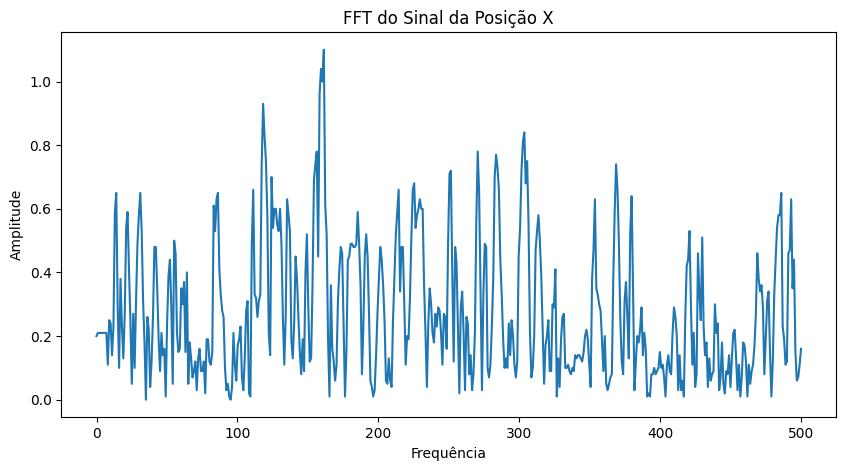

In [ ]:
# documentação: https://numpy.org/doc/stable/reference/routines.fft.html

import numpy as np
signal = data[['x']] # vou seguir apenas para a posição x

fft_signal = np.fft.fft(signal) # para o domínio da frequência
absolute_fft_signal = np.abs(fft_signal) # coeficientes da FFT (valor absoluto)
signal_length = len(signal) # comprimento original

frequencies = np.linspace(0, int(signal_length / 2), int(signal_length / 2))

plt.figure(figsize=(10, 5))
plt.plot(frequencies, absolute_fft_signal[:signal_length // 2])
plt.title('FFT do Sinal da Posição X')
plt.xlabel('Frequência')
plt.ylabel('Amplitude')
plt.show()

Aplicando o método de janelamento Hanning:

# Janelamento de Hanning:

É uma técnica para análise de sinais que reduz vazamento espectral e melhora a resolução em frequência:


$ w(n) = 0.5 - 0.5 \cos\left( \frac{2\pi n}{N-1} \right) $


( w(n) \) é o valor da janela no tempo \( n \) e \( N \) é o número total de amostras.

Nesse caso, o janelamento é aplicado ao sinal de posição X do MPU6050 multiplicando o sinal pelo resultado da função de Hanning.

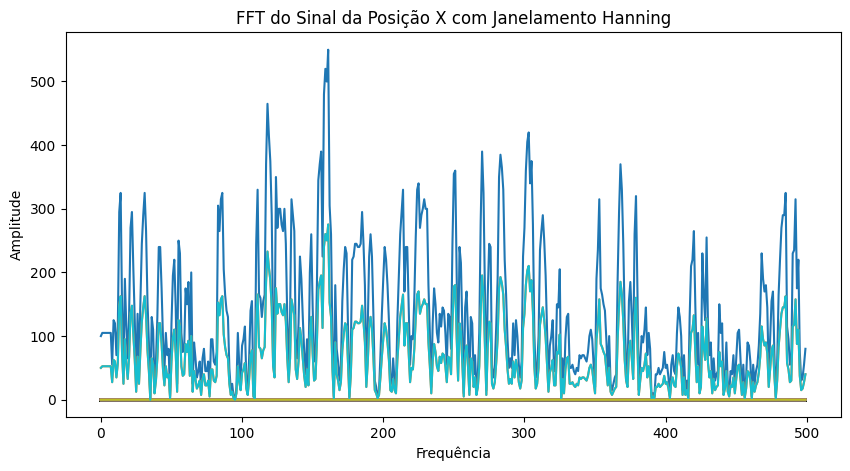

In [ ]:
signal = data[['x']]

data = pd.read_csv('/content/drive/MyDrive/mildadosMPU6050.csv')
signal = signal.to_numpy()

signal_length = len(signal)
fft_signal = np.fft.fft(signal)

# janelamento no sinal
window = np.hanning(signal_length) # Hanning
windowed_signal = signal * window

windowed_fft_signal = np.fft.fft(windowed_signal)
# coeficientes do sinal janelado
absolute_windowed_fft_signal = np.abs(windowed_fft_signal)
# o valor absoluto dos coeficientes da FFT

frequencies = np.linspace(0, int(signal_length / 2), int(signal_length / 2))

plt.figure(figsize=(10, 5))
plt.plot(absolute_windowed_fft_signal[:signal_length // 2])
plt.title('FFT do Sinal da Posição X com Janelamento Hanning')
plt.xlabel('Frequência')
plt.ylabel('Amplitude')
plt.show()

# Cálculo da Potência Média:

É a medida da energia média do sinal ao longo do tempo calculando o valor absoluto do sinal e elevando ao quadrado para obter a potência instantânea em cada amostra.
Logo, a potência média pode ser calculada com essas potências médias instantâneas.

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/mildadosMPU6050.csv')

signal = data[['x']]
signal = signal.to_numpy()

# a potência média do sinal
power_mean = np.mean(np.abs(signal)**2)
print(f'A potência média do sinal é: {power_mean}')

A potência média do sinal é: 0.173161


Convertendo o sinal na frequência para o domínio no tempo usando a função Ifft(x) e comparando se o mesmo está fiel ao comportamento original:

# Transformada Inversa de Fourier (IFFT):

É utilizada para converter um sinal do domínio da frequência para o domínio do tempo.


$ x(n) = \frac{1}{N} \sum_{k=0}^{N-1} X(k) \cdot e^{i2\pi kn/N} $


\( x(n) \) é a amostra do sinal no tempo, \( X(k) \) é o coeficiente da transformada de Fourier, e \( N \) é o número total de amostras.

Nesse caso, a IFFT é aplicada ao sinal de posição X após o janelamento de Hanning e a transformada FFT para reconstruir o sinal no domínio do tempo e comparar com o sinal original.

No gráfico é a comparação do sinal original e o sinal convertido após a IFFT, pra avaliar a fidelidade da transformação.

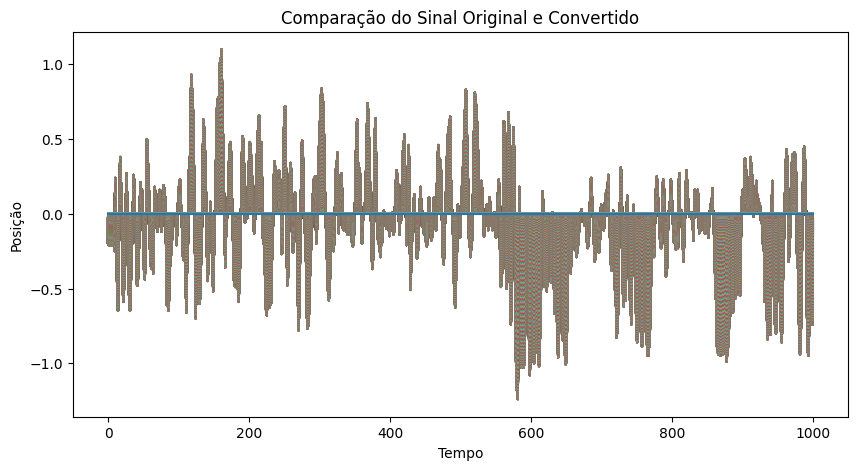

In [ ]:
signal = data[['x']]
signal = signal.to_numpy()

fft_signal = np.fft.fft(signal)

window = np.hanning(len(signal)) # Hanning
windowed_signal = signal * window

windowed_fft_signal = np.fft.fft(windowed_signal) # da frequência (fft)
# pro domínio do tempo usando a função Ifft(x)
time_signal = np.fft.ifft(windowed_fft_signal)

time_signal = np.real(time_signal) # valor real do sinal (tempo)

plt.figure(figsize=(10, 5))
plt.plot(signal, label='Sinal Original')
plt.plot(time_signal, label='Sinal Convertido')
plt.title('Comparação do Sinal Original e Convertido')
plt.xlabel('Tempo')
plt.ylabel('Posição')
plt.show()

Introdução de um ruído branco a fim de comparação da FFT do Sinal Original e Sinal com Ruído (Posição X):

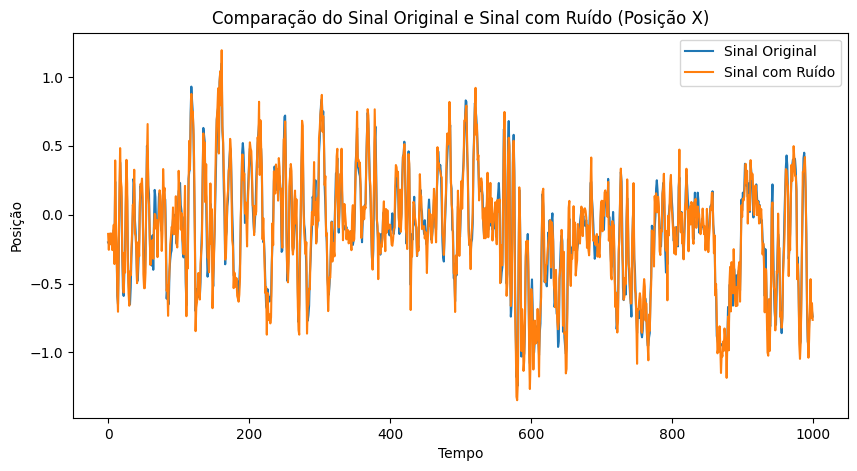

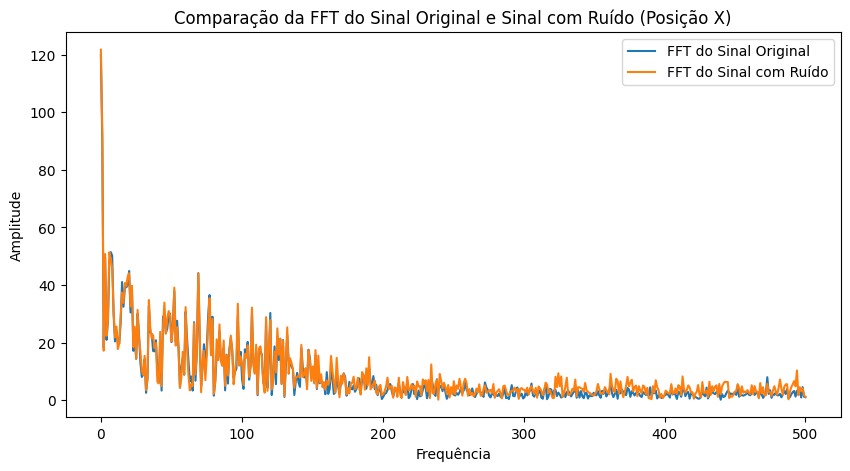

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/mildadosMPU6050.csv')
signal_x = data['x']

# ruído branco
noise_x = np.random.normal(0, 0.1, len(signal_x))  # média 0, desvio padrão 0.1

# add no sinal
signal_noisy_x = signal_x + noise_x

# sinal original e com ruído
plt.figure(figsize=(10, 5))
plt.plot(signal_x, label='Sinal Original')
plt.plot(signal_noisy_x, label='Sinal com Ruído')
plt.title('Comparação do Sinal Original e Sinal com Ruído (Posição X)')
plt.xlabel('Tempo')
plt.ylabel('Posição')
plt.legend()
plt.show()

# FFT para o sinal original e o sinal com ruído (para a posição x)
fft_signal_x = np.fft.fft(signal_x)
fft_signal_noisy_x = np.fft.fft(signal_noisy_x)

absolute_fft_signal_x = np.abs(fft_signal_x)
absolute_fft_signal_noisy_x = np.abs(fft_signal_noisy_x)

signal_length_x = len(signal_x)
frequencies_x = np.linspace(0, int(signal_length_x / 2),
                            int(signal_length_x / 2))

"""
fft_signal = np.fft.fft(signal) # para o domínio da frequência
absolute_fft_signal = np.abs(fft_signal) # coeficientes da FFT (valor absoluto)
signal_length = len(signal) # comprimento original
frequencies = np.linspace(0, int(signal_length / 2), int(signal_length / 2))
"""

plt.figure(figsize=(10, 5))
plt.plot(frequencies_x, absolute_fft_signal_x[:signal_length_x // 2], label='FFT do Sinal Original')
plt.plot(frequencies_x, absolute_fft_signal_noisy_x[:signal_length_x // 2], label='FFT do Sinal com Ruído')
plt.title('Comparação da FFT do Sinal Original e Sinal com Ruído (Posição X)')
plt.xlabel('Frequência')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

Demonstrando o efeito do coeficiente de Fourier em uma onda quadrada. Nessa demonstração, explore o efeito de Gibbs considerando n=2, n= 20, n=200 e n=2000. Plote tudo em uma única Figura.

$$ \frac{4}{\pi} \sum_{k=0}^{+\infty} \frac{1}{2k+1} sen\ 2\pi(2k+1)t $$

Text(0.5, 0, 'x')

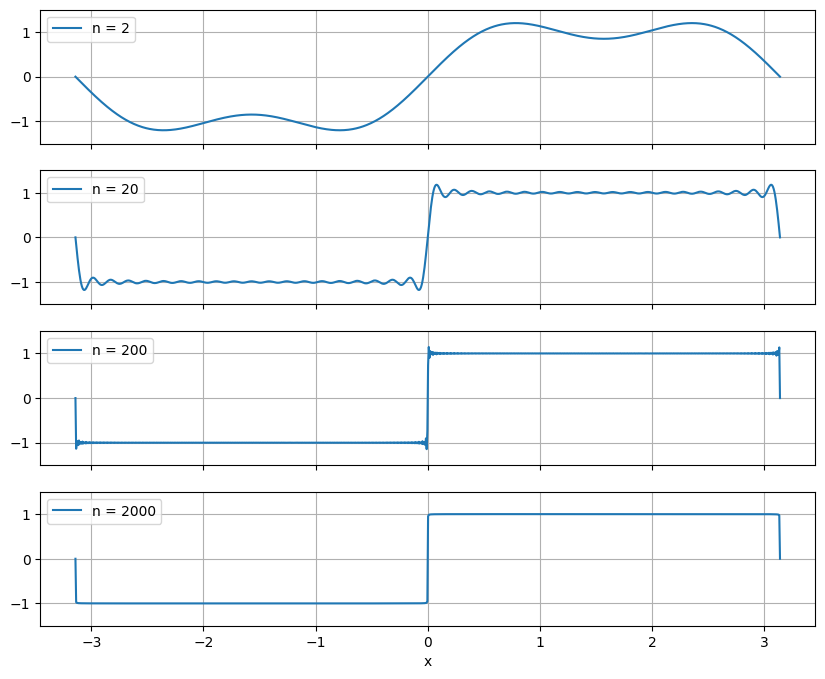

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# função para a série de Fourier (onda quadrada)
def onda_quadrada(x, n_termos):
    resposta = np.zeros_like(x)
    for n in range(1, n_termos + 1):
        resposta += (4 / np.pi) * (1 / (2 * n - 1)) * np.sin((2 * n - 1) * x)
    return resposta

n_val = [2, 20, 200, 2000]

x = np.linspace(-np.pi, np.pi, 1000)
fig, axs = plt.subplots(len(n_val), 1, figsize=(10, 8), sharex=True)
for i, n in enumerate(n_val):
    y = onda_quadrada(x, n)
    axs[i].plot(x, y, label=f'n = {n}')
    axs[i].legend(loc='upper left')
    axs[i].grid(True)
    axs[i].set_ylim([-1.5, 1.5])

axs[-1].set_xlabel('x')
